## FDW Crop Production Data Profiling - Mozambique

In [1]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [2]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('./data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32766'
fn_shapes = sorted(glob.glob('./data/shapefile/fewsnet/MZ_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
#read in username and password
exec(open('/Users/wanders7/Documents/Code/Logins/FDW.py').read())
auth = (username, password)
parameters = {
    'format': 'json',
    'country': 'Mozambique',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   |
| 1990	 | MZ1990A1 | 11	| MZ1990A2	| 142	|
| 2013	 | MZ2013A1 | 11	| MZ2013A2	| 154	|
| 2021	 | MZ2021A1 | 11	| MZ2021A2	| 160	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'

#Drop the hundreds of blank (nan) rows that are duplicates of rows that do have data
df = df[np.isfinite(df.value)]
#There are also 462 rows that are direct duplicates (same value) 
#with slightly different source data names for the same source, example below
#Directorate of Planning and International Cooperation (DPCI) --- Anuário de Estatísticas Agrárias
#Directorate of Planning and International Cooperation (DPCI) --- Anuário de Estatísticas Agrárias, Mozambique
# we will keep the more recent of these entries
rows = ['fnid','crop_production_system','season_year', 'product','indicator']
df['collection_date'] = pd.to_datetime(df['collection_date'])
df = df.sort_values(by=['collection_date']).drop_duplicates(rows, keep='last').reset_index(drop=True)

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #


# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([MZ_Admin1_1990,MZ_Admin1_2013], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 1,496
Removed 12 "Missing Value" points
530/534 "Yield" points are retained.
449/449 "Area Planted" points are retained.
505/513 "Quantity Produced" points are retained.
Current data points: 1,484

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1999 - 2018
5 grain types are found: Maize (Corn), Millet, Rice (Paddy), Sorghum, Wheat Grain
1 seasons are found: Main harvest (03-01)
1 crop production system are found: none
Data sources include:
[1] Ministério da Agricultura e Segurança Alimentar --- FEWS Agro_Maps
[2] Ministério da Agricultura e Segurança Alimentar --- Anuário de Estatísticas Agrárias
[3] Directorate of Planning and International Cooperation (DPCI) --- Anuário de Estatísticas Agrárias, Mozambique
[4] Directorate of Planning and International Cooperation (DPCI) --- Anuário de Estatísticas Agrárias
[5] Instituto Nacional de Estatística ---

## Mozambique
Mozambique crop seasonal calendar

![FEWS NET](https://fews.net/sites/default/files/styles/large/public/seasonal-calendar-mozambique.png?itok=XEl0lyNf)

![USDA](https://ipad.fas.usda.gov/countrysummary/images/MZ/cropcalendar/safrica_mz_calendar.png)

- comparison of boundaries
![image](./figures/MZ_admin_shapes.png)

- In Mozambique, basd on the FEWS NET data, there were two changes in administrative units: 1990, 2013, and 2021
- While the admin unit 1 doesn't change between 1990 and 2013, we will still need to map between FNIDs

| year	 | Admin1   | # units   | Admin2   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1990	 | MZ1990A1 | 11	| MZ1990A2	| 142	|
| 2013	 | MZ2013A1 | 11	| MZ2013A2	| 154	|
| 2021	 | MZ2021A1 | 11	| MZ2021A2	| 160	|

- The data is all reported in a single main season
- While there is a shapefile for 2021, there is no crop data associated with the 2021 shapefile, so we use 2013 as the most recent shapefile

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = MZ_Admin1_2013.copy().to_crs('epsg:32766')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [5]:
# Link admin boundaries ------------------------- #
link_1990, over_1990 = FDW_PD_CreateAdminLink(MZ_Admin1_1990, MZ_Admin1_2013, 'ADMIN1', 'ADMIN1', prod, epsg)

# Crop specific ratios
link_ratio = FDW_PD_RatioAdminLink(link_1990, prod, over_1990, mdx_pss)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
    
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

CBR is considered for 'MZ1990A106' as no record found in: ['MZ2013A106']


In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "growing year"
cols = ['season_name','product','crop_production_system','growing_month','harvest_year','harvest_month','growing_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','growing_year','growing_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack_gscd = stack[names]
stack_gscd['gscd_code'] = 'calibrated'
# ----------------------------------------------- #

# Reported FDW data ----------------------------- #
stack_fdw = df[names]
stack_fdw['indicator'] = stack_fdw['indicator'].replace({'Area Harvested':'area','Quantity Produced':'production','Yield':'yield'})
stack_fdw['gscd_code'] = 'reported'
# ----------------------------------------------- #

# Final Processing ------------------------------ #
stack = pd.concat([stack_fdw,stack_gscd], axis=0).reset_index(drop=True)
# No concerns found for grain types
stack['product'] = stack['product'].replace(product_category)
# Calibration of Growing and Harvest year and season
cs = {
    'Main harvest': {'growing_month':{'03-01':'03-01'},'harvest_month':{'06-01':'06-01'}},
}
cy = {}
stack, df, link_ratio = FDW_PD_CaliSeasonYear(stack, df, link_ratio, cs, cy)
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# # ----------------------------------------------- #

# Save data
save_hdf('./data/crop/adm_crop_production_MZ.hdf', stack)
save_hdf('./data/crop/adm_crop_production_MZ_raw.hdf', df)
save_npz('./data/crop/adm_crop_production_MZ_ratio.npz', link_ratio)

./data/crop/adm_crop_production_MZ.hdf is saved.
./data/crop/adm_crop_production_MZ_raw.hdf is saved.
./data/crop/adm_crop_production_MZ_ratio.npz is saved.


## Visualization of production data

./figures/MZ_bar_natgrainprod_Main harvest.png is saved.


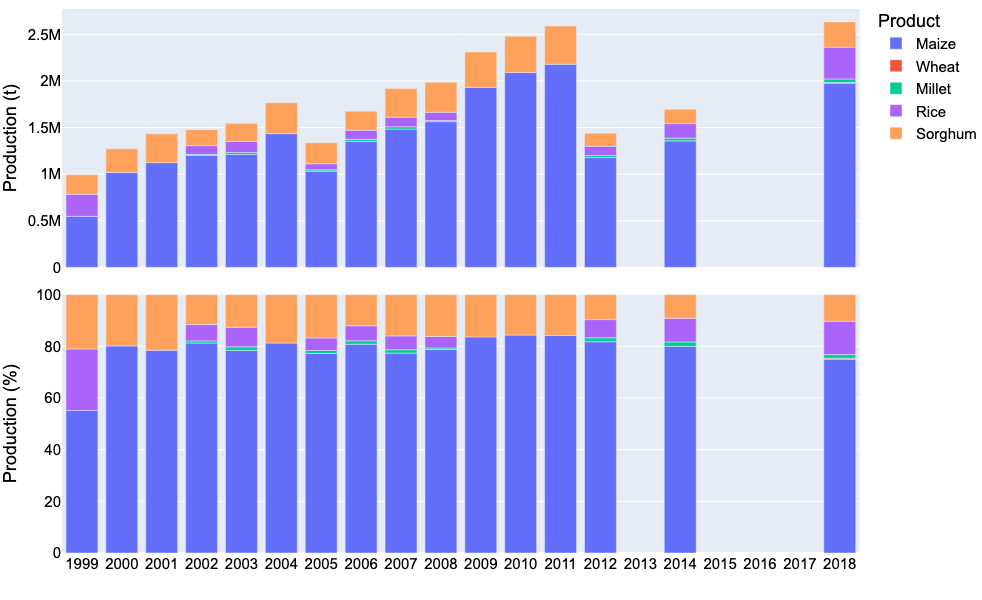

In [7]:
# Bar chart of national grain production
country_iso, country_name = 'MZ', 'Mozambique'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_order = ['Maize', 'Wheat','Millet', 'Rice','Sorghum']
for season_name in ['Main harvest']:
    footnote = 'National grain production in %s - %s' % (country_name, season_name)
    fn_save = './figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    fig = PlotBarProduction(sub, year, product_order, footnote, fn_save)
    fig.show()

./figures/MZ_line_pay_Millet_Main harvest.png is saved.


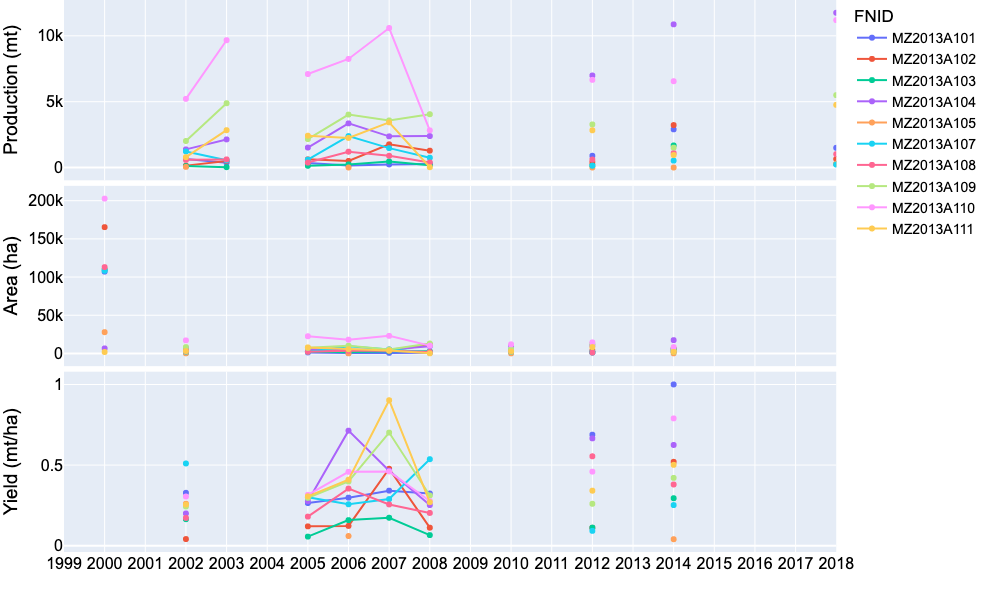

./figures/MZ_line_pay_Sorghum_Main harvest.png is saved.


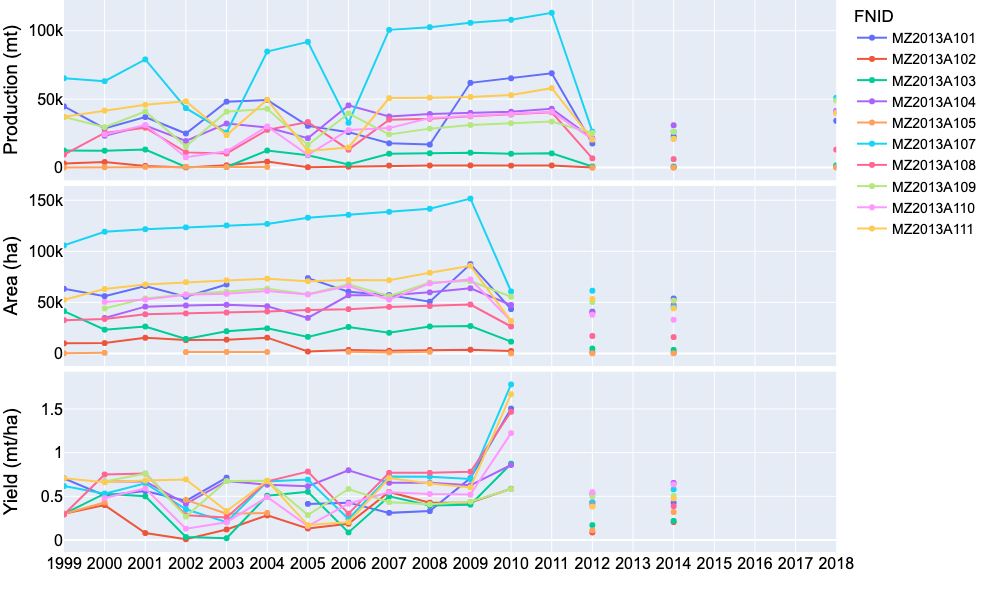

./figures/MZ_line_pay_Maize_Main harvest.png is saved.


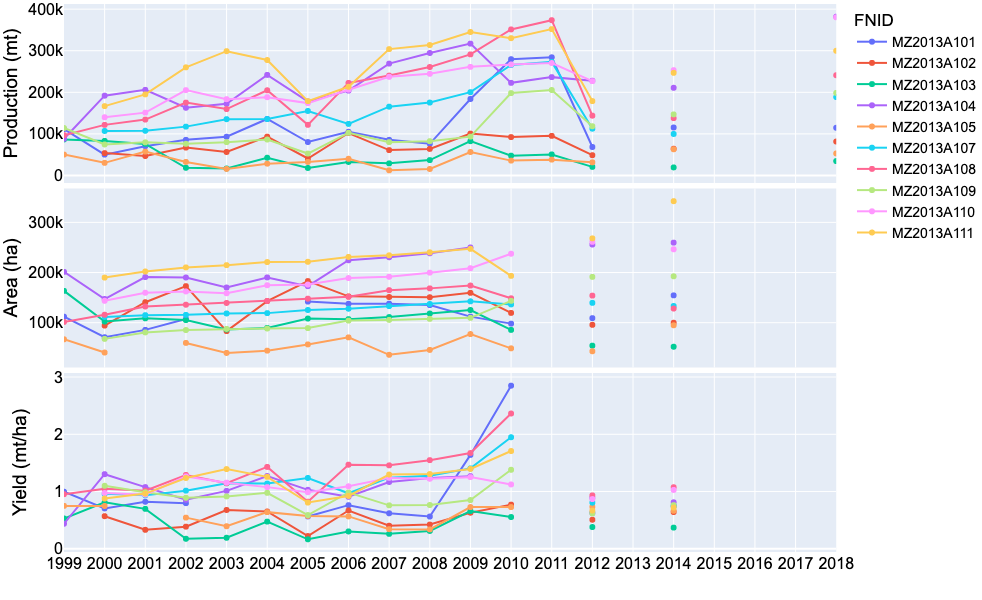

./figures/MZ_line_pay_Rice_Main harvest.png is saved.


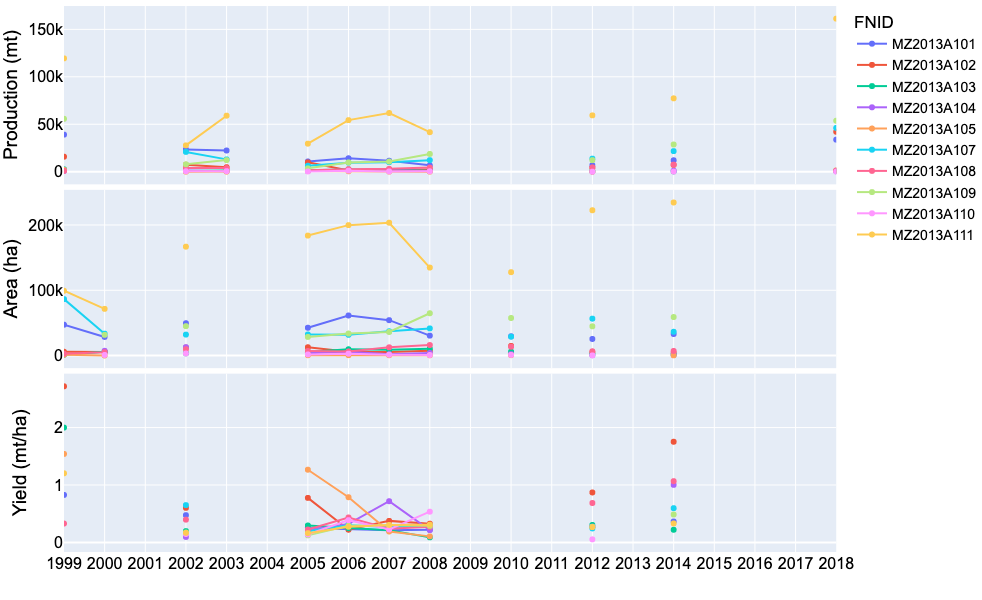

./figures/MZ_line_pay_Wheat_Main harvest.png is saved.


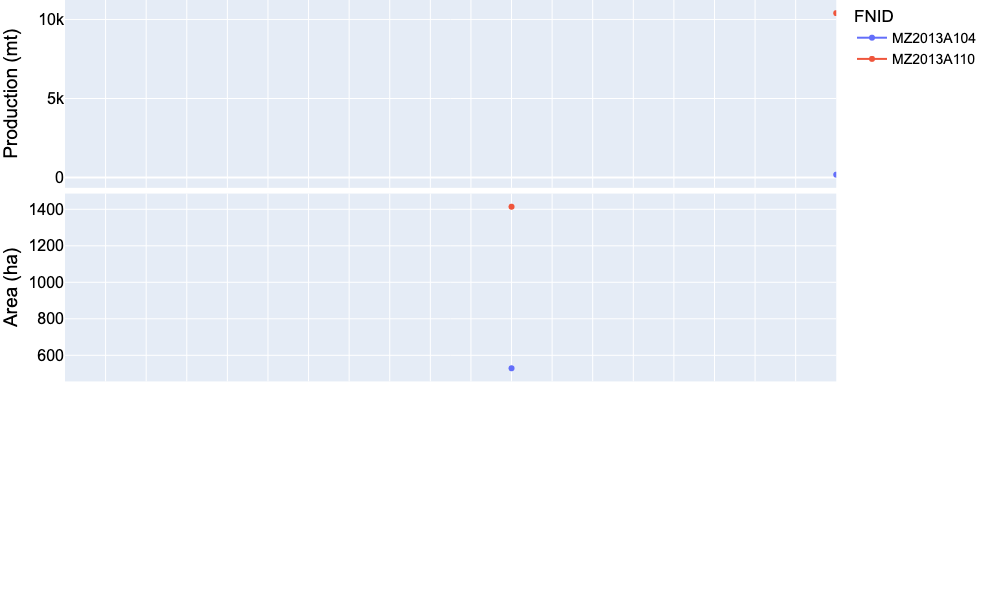

In [8]:
# Lineplot of Production-Area-Yield (PAY) time-series
country_iso, country_name ='MZ', 'Mozambique'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Millet','Main harvest'],
    ['Sorghum','Main harvest'],
    ['Maize','Main harvest'],
    ['Rice','Main harvest'],
    ['Wheat','Main harvest'],
]
for product_name, season_name in product_season:
    footnote = 'Production-Area-Yield (PAY) time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = './figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    fig = PlotLinePAY(sub, year, footnote, fn_save)
    fig.show()

In [9]:
# Calibrated PAY time-series per FNID
from tools_graphic import PlotLineCropTS
country_iso, country_name = 'MZ', 'Mozambique'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
link_ratio = load_npz('./data/crop/adm_crop_production_%s_ratio.npz' % country_iso)
year_all = np.arange(df['year'].min(), df['year'].max()+1)
product_season = [
    ['Millet','Main harvest'],
    ['Sorghum','Main harvest'],
    ['Maize','Main harvest'],
    ['Rice','Main harvest'],
    ['Wheat','Main harvest'],
]
for product_name, season_name in product_season:
    sub = df[
        (df['product'] == product_name) &
        (df['season_name'] == season_name)
    ]
    for fnid in sub['fnid'].unique():
        sub_fps = sub[sub['fnid'] == fnid]
        fn_save = './figures/crop_calibrated/%s_%s_%s_%s.png' % (country_iso, product_name, season_name, fnid)
        fig = PlotLineCropTS(sub_fps, fnid, product_name, season_name, link_ratio, year_all, fn_save)

./figures/crop_calibrated/MZ_Millet_Main harvest_MZ2013A101.png is saved.
./figures/crop_calibrated/MZ_Millet_Main harvest_MZ2013A102.png is saved.
./figures/crop_calibrated/MZ_Millet_Main harvest_MZ2013A103.png is saved.
./figures/crop_calibrated/MZ_Millet_Main harvest_MZ2013A105.png is saved.
./figures/crop_calibrated/MZ_Millet_Main harvest_MZ2013A107.png is saved.
./figures/crop_calibrated/MZ_Millet_Main harvest_MZ2013A108.png is saved.
./figures/crop_calibrated/MZ_Millet_Main harvest_MZ2013A111.png is saved.
./figures/crop_calibrated/MZ_Millet_Main harvest_MZ2013A104.png is saved.
./figures/crop_calibrated/MZ_Millet_Main harvest_MZ2013A109.png is saved.
./figures/crop_calibrated/MZ_Millet_Main harvest_MZ2013A110.png is saved.
./figures/crop_calibrated/MZ_Sorghum_Main harvest_MZ2013A101.png is saved.
./figures/crop_calibrated/MZ_Sorghum_Main harvest_MZ2013A102.png is saved.
./figures/crop_calibrated/MZ_Sorghum_Main harvest_MZ2013A103.png is saved.
./figures/crop_calibrated/MZ_Sorghu

In [10]:
# Heatmap of seasonal data availability
country_iso, country_name = 'MZ', 'Mozambique'
df = pd.read_hdf('./data/crop/adm_crop_production_%s_raw.hdf' % country_iso)
df['year'] = df['harvest_year']
code = {'Main season':1}
comb = {1:1,10:2,11:3}
comb_name = {1:'Main harvest'}
for product_name in ['Sorghum','Millet','Maize']:
    fig = plt.figure()
    data = df[(df['product'] == product_name) & (df['season_name'].isin(code.keys()))]
    footnote = 'Seasonal data availability in %s - %s (uncorrected)' % (country_name, product_name)
    fn_save = './figures/%s_heat_seasondata_%s.png' % (country_iso, product_name)
    plt = PlotHeatSeasonData(data, code, comb, comb_name, footnote, fn_save)

NameError: name 'plt' is not defined